In [1]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.0 MB/s eta 0:00:00


In [2]:
!pip install torchsummary

# 1. Import Dependencies

In [3]:
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2, ToTensor
from torchsummary import summary
from torchmetrics import Accuracy, F1Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter('ignore')

sns.set(style = 'whitegrid', palette = 'Set2')

/Users/leger/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/leger/Library/Python/3.9/lib/python/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/leger/Library/Python/3.9/lib/python/site-pack

# 2. Preprocessing

In [34]:
random_seed = 42
root_dir = 'brain/'

folder_yes = os.listdir(root_dir + 'yes')
folder_no = os.listdir(root_dir + 'no')

samples, labels = [], []

# Walk through the directory tree
for root, directories, files in os.walk(root_dir):
    print(f"Current directory: {root}")
    # Print files in the current directory
    for file in files:
        if ('yes' in root):
            labels.append(1)
            samples.append(os.path.join(root, file))
        if ('no' in root):
            labels.append(0)
            samples.append(os.path.join(root, file))

print(f'\nLength of Samples: {len(samples)}')
print(f'Length of Labels: {len(labels)}')

X_train, X_test, y_train, y_test = train_test_split(np.array(samples), np.array(labels), test_size = 0.2, random_state = random_seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = random_seed)

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

Current directory: brain/
Current directory: brain/no
Current directory: brain/train
Current directory: brain/yes

Length of Samples: 253
Length of Labels: 253


((202,), (25,), (26,), (202,), (25,), (26,))

<BarContainer object of 2 artists>

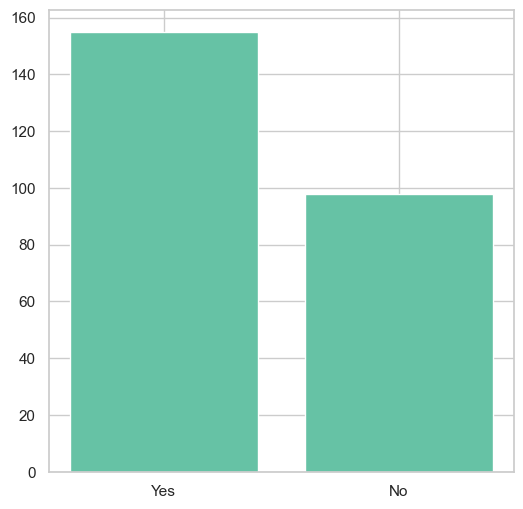

In [35]:
plt.figure(figsize = (6, 6))
plt.bar(['Yes', 'No'], [len(folder_yes), len(folder_no)])

In [36]:
# Create custom dataset
class BrainMRIDataset(Dataset):
    def __init__(self, data, labels, transforms = None):
        self.data = data
        self.targets = labels
        self.transforms = transforms
    
    def display_samples(self, grid_size = 3, figsize = (10, 10), axis = False):
        fig = plt.figure(figsize = figsize)
        
        for i in range(grid_size * grid_size):
            rand_idx = np.random.randint(0, len(self.data))
            
            img, target = Image.open(self.data[rand_idx]).convert('L'), self.targets[rand_idx]
            if self.transforms:
                img = self.transforms(img)
            color = 'green' if self.targets[rand_idx] == 1 else 'red'
            
            plt.subplot(grid_size, grid_size, i + 1)
            plt.imshow(img.squeeze(), cmap = 'gray')
            plt.title(f"Brain Tumor: {'YES' if self.targets[rand_idx] == 1 else 'NO'}", color = color)
            plt.axis(axis)
            
            if axis:
                plt.xlabel(f'Index : {rand_idx}')
            
        fig.tight_layout()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = Image.open(self.data[idx]).convert('L')
        if self.transforms:
            data = self.transforms(data)
        return data, torch.tensor(self.targets[idx], dtype = torch.float32)
    
transforms = v2.Compose([
    v2.ToImageTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize((144, 144)),
    v2.RandomVerticalFlip(p = 0.5),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.Normalize(mean=[0.485], std=[0.229]),
])

batch_size = 16

train_data = BrainMRIDataset(X_train, y_train, transforms)
test_data = BrainMRIDataset(X_test, y_test, transforms)
val_data = BrainMRIDataset(X_val, y_val, transforms)

train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = False)
val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle = True)

## Training Samples

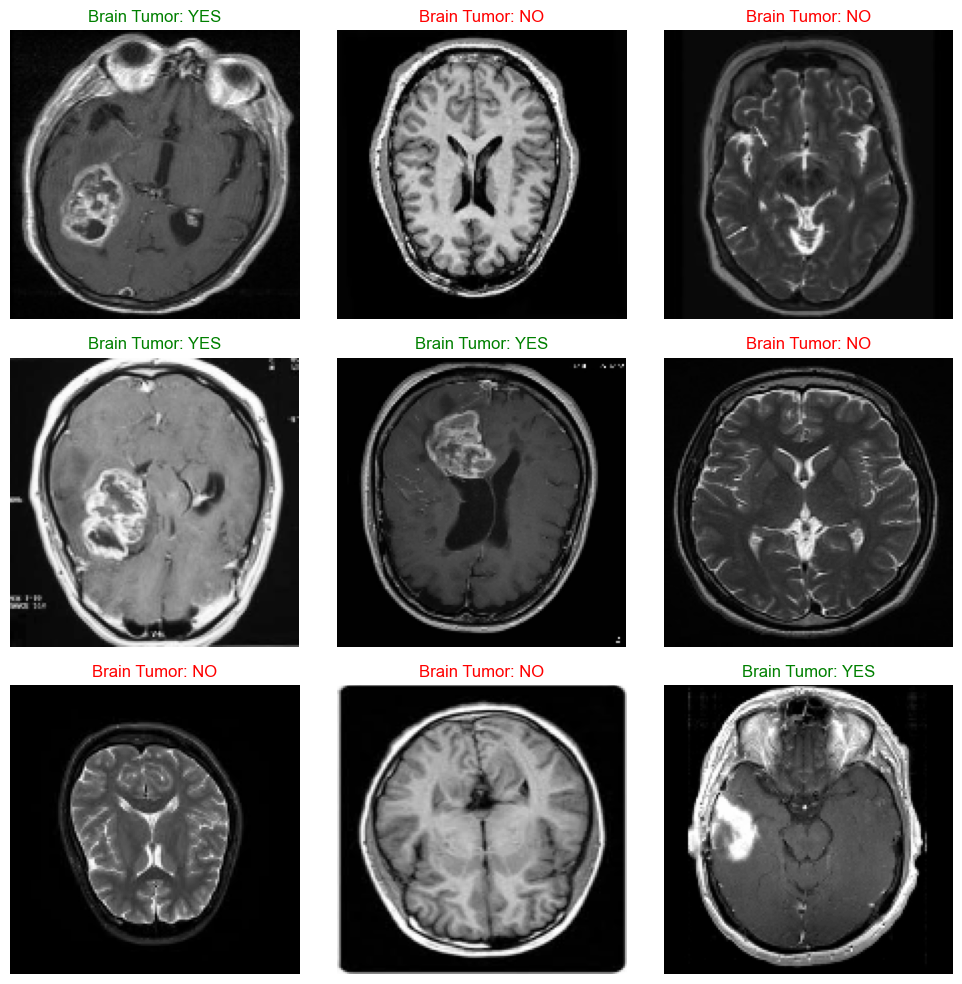

In [8]:
train_data.display_samples()

## Test Samples

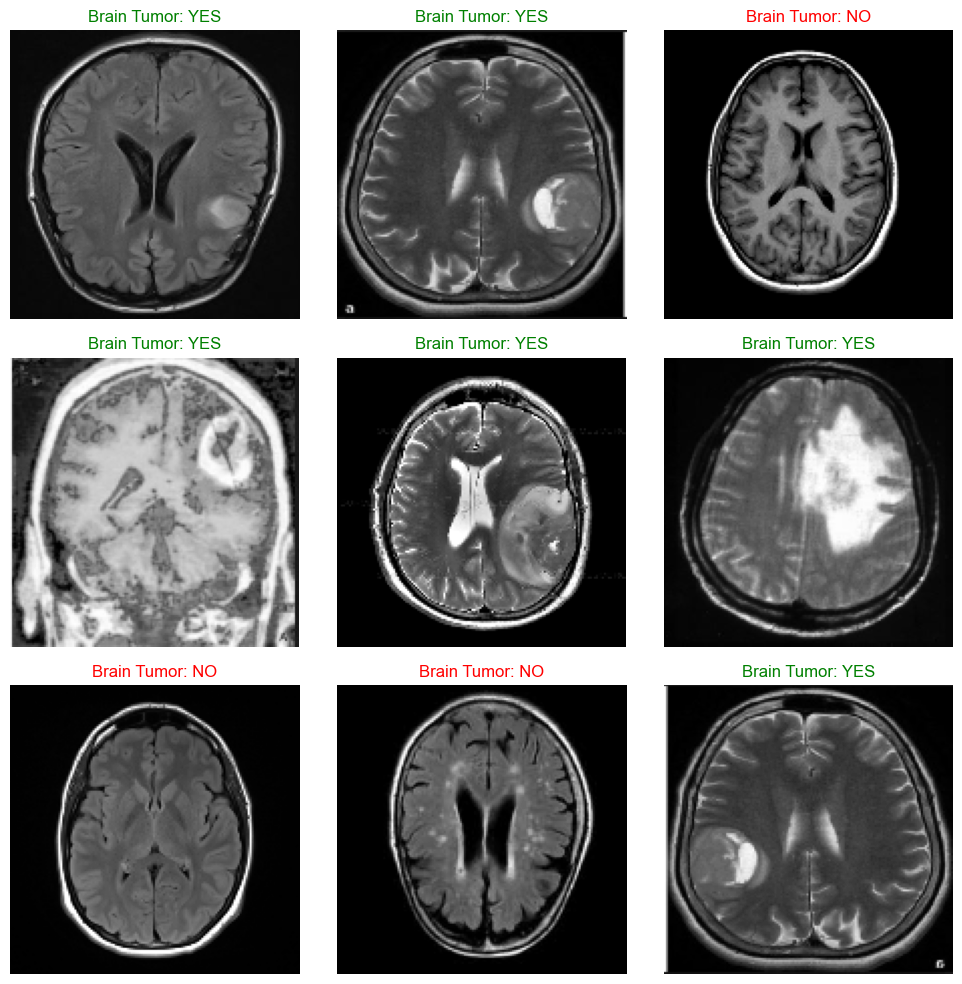

In [9]:
test_data.display_samples()

## Validation Samples

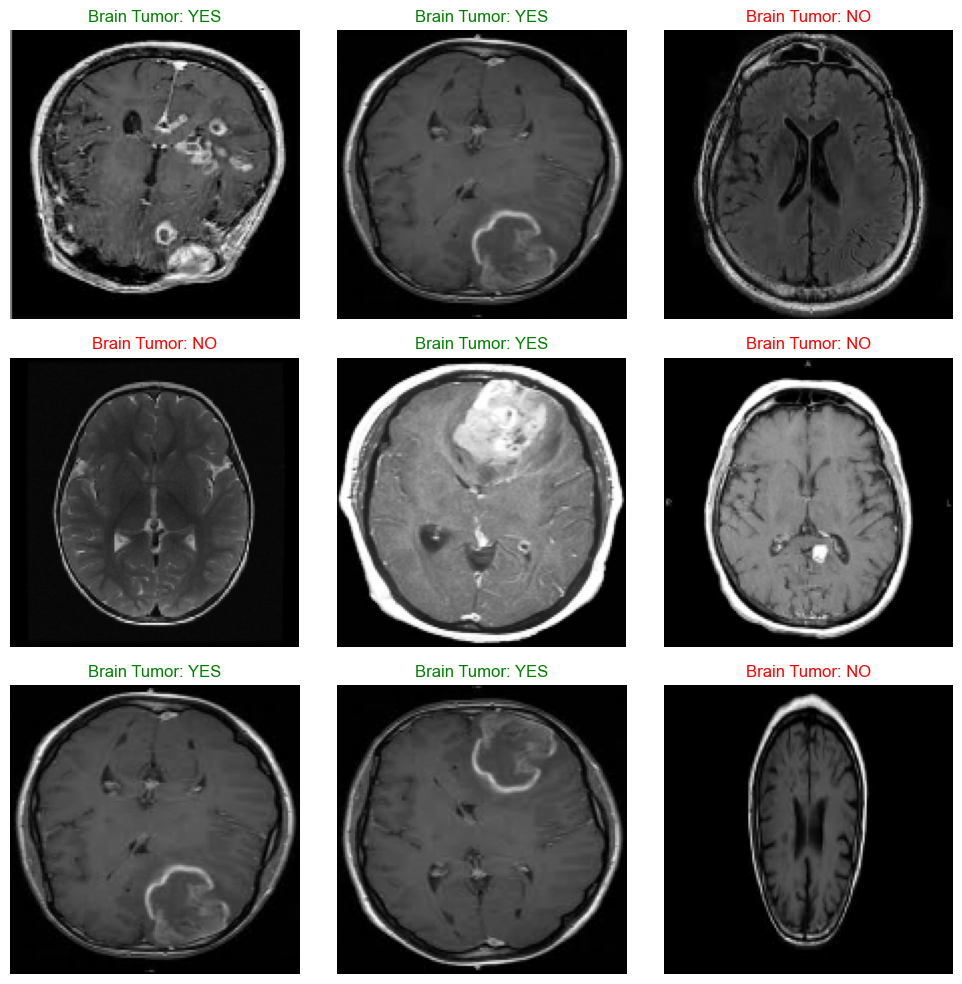

In [10]:
val_data.display_samples()

# 3. Patch Embedding


In [11]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 1, patch_size: int = 16, emb_size: int = 768, img_size = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size = patch_size, stride = patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')) # batch, embeddings, height, width -> batch (height x width) embeddings
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size)**2+1, emb_size)) # +1, accounting for cls_token
                
    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b = b)
        x = torch.cat([cls_tokens, x], dim = 1)
        x += self.positions
        return x

In [13]:
# Let's test out our PatchEmbedding class
sample = train_data[0][0].unsqueeze(0) # let's add a batch dimension -> output shape: [1, 1, 144, 144]
embedding = PatchEmbedding(in_channels = sample.shape[0], 
                          patch_size = 16, 
                          emb_size = 768,
                          img_size = sample.shape[2])(sample)
print(f'Sample Original Shape: {sample.shape}')
print(f'Sample Embedding Shape: {embedding.shape}')

Sample Original Shape: torch.Size([1, 1, 144, 144])
Sample Embedding Shape: torch.Size([1, 82, 768])


# 4. Multi-Head Attention

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0.):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
    
    def forward(self, x, mask = None):
        # 1. Split keys, queries, and values in num_heads
        qkv = rearrange(self.qkv(x), 'b n (h d qkv) -> (qkv) b h n d', h = self.num_heads, qkv = 3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        
        # 2. Sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        
        scaling = self.emb_size ** (1/2)
            
        att = F.softmax(energy, dim = -1) / scaling
        att = self.att_drop(att)
        
        # Sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav', att, values)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.projection(out)
        return out, att

In [15]:
MultiHeadAttention()(embedding).shape

torch.Size([1, 82, 768])

# 5. Feed Forward Network

In [17]:
class FeedForward(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
            nn.Dropout(drop_p)
        )
ff = FeedForward(emb_size = 768)
ff(embedding).shape

torch.Size([1, 82, 768])

# 6. Skip Connections

In [18]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

# 7. Transformer Encoder Block

In [38]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size: int = 768, drop_p: float = 0.1, forward_expansion: int = 4, forward_drop_p: float = 0., **kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size), 
            MultiHeadAttention(emb_size, **kwargs), 
            nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            FeedForward(emb_size, expansion = forward_expansion, drop_p = forward_drop_p),
            nn.Dropout(drop_p)))
        )

class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [39]:
TransformerEncoderBlock()(embedding).shape

torch.Size([1, 82, 768])

# 8. Classification Head

In [40]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1):
        super().__init__(
            Reduce('b n e -> b e', reduction = 'mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

# 9. Visual Transformer

In [41]:
class ViT(nn.Sequential):
    def __init__(self, 
                in_channels: int = 1, 
                patch_size: int = 4, 
                emb_size: int = 64, 
                img_size: int = 144, 
                depth: int = 3, 
                n_classes: int = 1,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size = emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def human_readable(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{:.2f}{}'.format(num, ['', 'K', 'M', 'B', 'T'][magnitude])
print(human_readable(count_parameters(ViT())))

234.31K


# 10. Training and Predictions

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ViT().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.BCEWithLogitsLoss()
acc_fn = Accuracy(task = 'binary').to(device)
f1_fn = F1Score(task = 'binary').to(device)

In [44]:
def train(model, dataloader, loss_fn, metric_fn, optimizer, device):
    loss, metric_score = 0, 0
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        logits = model(X).squeeze()
        
        batch_loss = loss_fn(logits, y)
        metric_score += metric_fn(logits, y)
        
        loss += batch_loss
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    
    loss /= len(dataloader)
    metric_score /= len(dataloader)
    
    print(f'Training -- Loss: {loss:.4f}, F1: {metric_score*100:.2f}%')
    
def validate(model, dataloader, loss_fn, metric_fn, device):
    loss, metric_score = 0, 0
    
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            logits = model(X).squeeze()
            loss += loss_fn(logits, y)
            metric_score += metric_fn(logits, y)
        
        loss /= len(dataloader)
        metric_score /= len(dataloader)
        
        print(f'Validation -- Loss: {loss:.4f}, F1: {metric_score*100:.2f}%')

In [45]:
epochs = 10
for epoch in range(epochs):
    print(f'Epoch : # {epoch}')
    print('-'*30+'\n')
    
    train(model, 
         train_dataloader, 
         loss_fn, 
         acc_fn,
         optimizer, 
         device)
    
    validate(model, 
            val_dataloader,
            acc_fn,
            f1_fn,
            device)
    
    print('\n')

Epoch : # 0
------------------------------

Training -- Loss: 0.6660, F1: 47.98%
Validation -- Loss: 0.5813, F1: 73.50%


Epoch : # 1
------------------------------

Training -- Loss: 0.6825, F1: 60.87%
Validation -- Loss: 0.4000, F1: 0.00%


Epoch : # 2
------------------------------

Training -- Loss: 0.6622, F1: 38.37%
Validation -- Loss: 0.4187, F1: 0.00%


Epoch : # 3
------------------------------

Training -- Loss: 0.6563, F1: 40.67%
Validation -- Loss: 0.6500, F1: 69.44%


Epoch : # 4
------------------------------

Training -- Loss: 0.6427, F1: 67.50%
Validation -- Loss: 0.6500, F1: 69.44%


Epoch : # 5
------------------------------

Training -- Loss: 0.6211, F1: 67.12%
Validation -- Loss: 0.6250, F1: 68.18%


Epoch : # 6
------------------------------

Training -- Loss: 0.5931, F1: 68.85%
Validation -- Loss: 0.6812, F1: 76.19%


Epoch : # 7
------------------------------

Training -- Loss: 0.5703, F1: 70.00%
Validation -- Loss: 0.6562, F1: 71.27%


Epoch : # 8
--------------

In [46]:
def predict(model, test_dataloader, loss_fn, metric_fn, device):
    y_true, y_pred = [], []
    loss, metric_score = 0, 0
    
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            
            y_true.extend(y)
            
            logits = model(X).squeeze()
            y_pred.extend(torch.round(torch.sigmoid(logits)))
            
            loss += loss_fn(logits, y)
            metric_score += metric_fn(logits, y) 
            
        loss /= len(test_dataloader)
        metric_score /= len(test_dataloader)
    
    return torch.tensor(y_true), torch.tensor(y_pred)

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

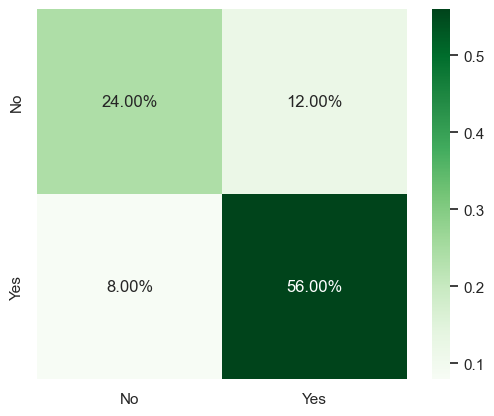

In [47]:
y_true, y_pred = predict(model, test_dataloader, loss_fn, acc_fn, device)

vit_cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(vit_cm/np.sum(vit_cm), annot = True, fmt = '.2%', square = True, cmap = 'Greens')
ax.set_xticklabels(['No', 'Yes'])
ax.set_yticklabels(['No', 'Yes'])

In [48]:
def predict_on_random_images(model, dataset, grid_size = 3, figsize = (10, 10), device = 'cpu'):
    fig = plt.figure(figsize = figsize)
    for i in range(grid_size * grid_size):
        rand_idx = np.random.randint(0, len(dataset))
        img, label = dataset[rand_idx]
        
        model.eval()
        with torch.inference_mode():
            pred = torch.round(torch.sigmoid(model(img.unsqueeze(0).to(device))))
            
        color = 'green' if label == pred else 'red'
        
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img.squeeze(), cmap = 'gray')
        plt.title(f"Actual: {'Yes' if label == 1 else 'No'} | Pred: {'Yes' if pred == 1 else 'No'}", color = color)
        plt.axis(False)
    
    fig.tight_layout()

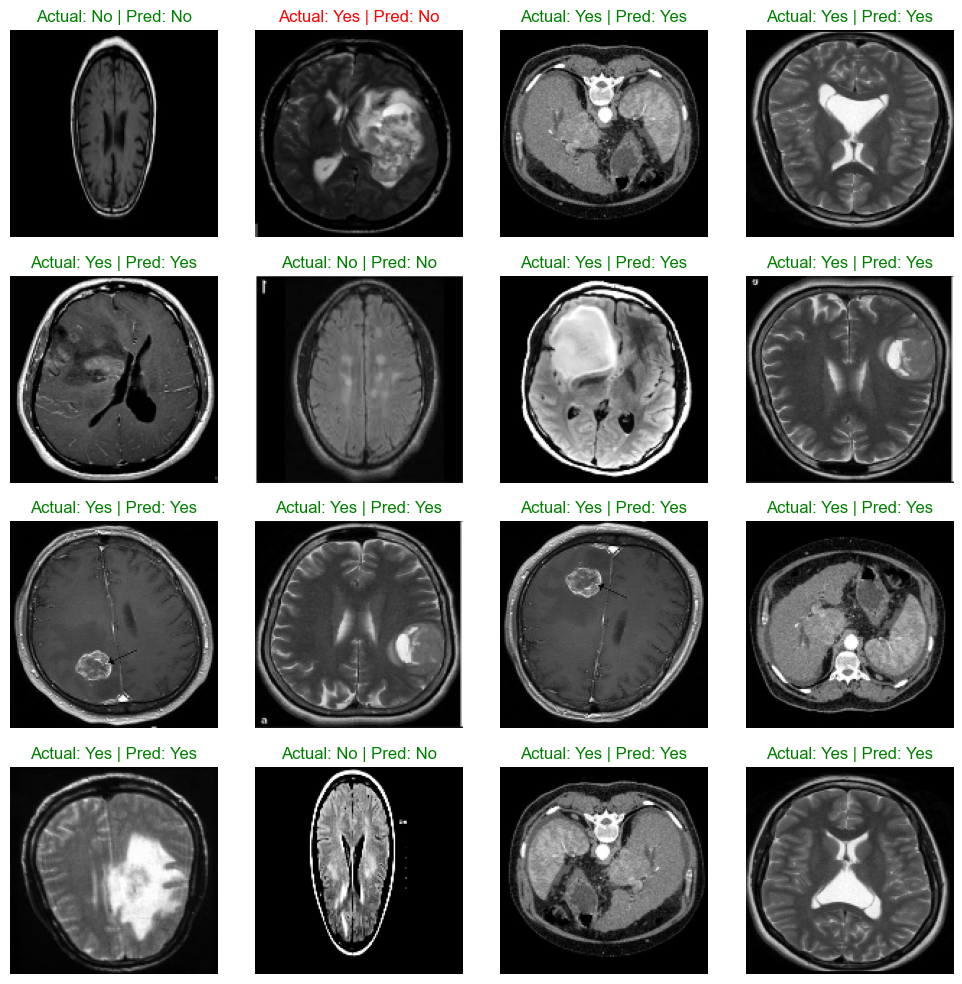

In [50]:
predict_on_random_images(model, test_data, grid_size = 4, device = device)